Potential TODO:


- Work on refining best models
- Visualising some predictions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from tabulate import tabulate

from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [26]:
modelling_df = pd.read_csv('Dataset/output_dataset.csv')

In [27]:
# Convert 'country', 'account_currency', 'Trading_Method' and 'active' to categorical
modelling_df['country'] = modelling_df['country'].astype('category')
modelling_df['account_currency'] = modelling_df['account_currency'].astype('category')
modelling_df['Trading_Method'] = modelling_df['Trading_Method'].astype('category')
modelling_df['active'] = modelling_df['active'].astype('category')
modelling_df['has_credit'] = modelling_df['has_credit'].astype('category')

In [28]:
# Remove specified columns and set 'longevity' as the target variable
X = modelling_df.drop(columns=['login', 'Total_Trades', 'active', 'Average_Volume', 'longevity', 'longevity_bin'])
y = modelling_df['longevity']

In [29]:
# List of all numeric columns
all_numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# List of categorical columns
categorical_cols = ['country', 'account_currency', 'Trading_Method', 'has_credit']  # Specified based on the dataset information provided earlier

# Columns to exclude from scaling
exclude_scaling = ['Buy_Percentage', 'TP/SL Hit Ratio', 'Reward_Risk_Ratio', 'Ratio_Profitable_Trades', 'net_deposit_frequency_ratio']

# Numeric columns to be scaled
numeric_cols_to_scale = [col for col in all_numeric_cols if col not in exclude_scaling]

# Create transformers for numeric and categorical data
numeric_transformer = RobustScaler()
categorical_transformer = OrdinalEncoder()

# Create a column transformer to apply the appropriate transformations to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num_to_scale', numeric_transformer, numeric_cols_to_scale),
        ('num_no_scale', 'passthrough', exclude_scaling),  # Pass through without scaling
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply transformations to the features
X_preprocessed = preprocessor.fit_transform(X)

# Get numeric feature names directly for scaled and non-scaled
numeric_feature_names = numeric_cols_to_scale + exclude_scaling

# Combine all feature names
all_feature_names_corrected = numeric_feature_names + categorical_cols

# Creating the complete feature DataFrame with the correct feature names
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names_corrected)

In [30]:
X_preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5725 entries, 0 to 5724
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Trading_Frequency            5725 non-null   float64
 1   Average_Volume_USD           5725 non-null   float64
 2   Average_DPM                  5725 non-null   float64
 3   Unique_Symbols_Traded        5725 non-null   float64
 4   Peak_Trading_Times           5725 non-null   float64
 5   Profit_Loss_Variability      5725 non-null   float64
 6   Average_Trade_Duration       5725 non-null   float64
 7   Average_Commission           5725 non-null   float64
 8   Average_Swaps                5725 non-null   float64
 9   Average_Profit               5725 non-null   float64
 10  average_net_deposit          5725 non-null   float64
 11  Buy_Percentage               5725 non-null   float64
 12  TP/SL Hit Ratio              5725 non-null   float64
 13  Reward_Risk_Ratio 

In [31]:
X_preprocessed_df

,Trading_Frequency,Average_Volume_USD,Average_DPM,Unique_Symbols_Traded,Peak_Trading_Times,Profit_Loss_Variability,Average_Trade_Duration,Average_Commission,Average_Swaps,Average_Profit,average_net_deposit,Buy_Percentage,TP/SL Hit Ratio,Reward_Risk_Ratio,Ratio_Profitable_Trades,net_deposit_frequency_ratio,country,account_currency,Trading_Method,has_credit
0,1.219451,18.389751,0.133754,1.955556,0.285714,3.769439,0.383635,-6.935588,-24.382993,1.632630,-34.514759,47.485632,3.375000,0.086763,0.762931,0.056225,6.0,3.0,1.0,0.0
1,3.003094,-0.016366,-0.376042,0.400000,0.285714,-0.158953,0.766293,0.000000,-1.832092,0.056110,1.329348,49.635369,0.087081,-0.549598,0.718323,0.047809,41.0,7.0,2.0,0.0
2,0.470264,-0.016545,-6.507861,-0.266667,0.285714,-0.149662,0.579659,0.000000,0.035756,-0.502678,0.301433,15.942029,0.000000,0.000000,0.463768,0.004819,114.0,6.0,1.0,0.0
3,1.159722,-0.016422,0.174810,1.066667,-1.714286,-0.221091,-0.135303,0.000000,-0.381555,0.074743,-0.233830,63.529412,0.000000,0.000000,0.517647,0.007246,75.0,7.0,2.0,0.0
4,-0.197506,0.007317,0.051715,0.205128,-1.714286,-0.263700,0.134139,-0.101129,-0.160496,0.093413,0.372391,51.239669,0.002283,55.989328,0.311983,0.022388,5.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5720,-0.390730,0.721037,0.092639,0.355556,-1.000000,-0.198092,-0.174450,0.000000,-0.097635,0.097965,-0.244254,37.037037,0.000000,0.000000,0.796296,0.004914,21.0,1.0,2.0,0.0
5721,0.322315,56.825601,-0.442806,1.333333,1.142857,5.218928,1.067264,0.000000,-83.716289,-2.972653,0.158724,46.153846,6.823529,0.195671,0.658371,0.002625,75.0,7.0,1.0,0.0
5722,1.321155,0.676199,0.002715,2.488889,0.000000,-0.103424,-0.174913,-0.256347,-0.004468,0.015542,-0.272426,40.083507,2.760870,0.623201,0.626305,0.000000,114.0,7.0,1.0,0.0
5723,0.445991,-0.015841,0.414314,0.562963,0.285714,0.509714,1.136630,-0.700736,-2.059606,0.098487,-0.272426,58.805513,53.785714,0.225533,0.882083,0.000000,114.0,6.0,1.0,0.0


## Model Splitting

In [32]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_preprocessed_df, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15/0.85, random_state=42)

print(f"Train Set Size: {X_train.shape[0]}")
print(f"Test Set Size: {X_test.shape[0]}")
print(f"Validation Set Size: {X_val.shape[0]}")

Train Set Size: 4007
Test Set Size: 859
Validation Set Size: 859


## Model Comparison

In [43]:
# Define regression models
regression_models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(criterion='squared_error'),
    "XGBoost Regressor": XGBRegressor(objective='reg:squarederror', max_depth='5', eta='0.05', eval_metric='rmse', alpha='0.1', reg_lambda='1'),  
    "Neural Network Regressor": MLPRegressor(max_iter=10000),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "KNeighbors Regressor": KNeighborsRegressor(),
    "Support Vector Regressor": SVR()
}

In [44]:
def DisplayFeatureImportanceOrCoefficients(model):
    if hasattr(model, 'feature_importances_'):
        feature_importances = list(zip(X_preprocessed_df.columns, model.feature_importances_))
        headers = ["Feature", "Importance"]
        print("Feature Importances:")
        print(tabulate(feature_importances, headers=headers, tablefmt="rounded_outline"))
    elif hasattr(model, 'coef_'):
        feature_coefficients = list(zip(X_preprocessed_df.columns, model.coef_))
        headers = ["Feature", "Coefficient"]
        print("Feature Coefficients:")
        print(tabulate(feature_coefficients, headers=headers, tablefmt="rounded_outline"))
    else:
        print("Feature importance or coefficients not available for this model.")


In [45]:
def DisplayMetrics(model, X, y, metricType):
    y_pred = model.predict(X)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)

    headers = [metricType, "Value"]
    data = [
        ["Mean Absolute Error (MAE)", f"{mae:.4f}"],
        ["Mean Squared Error (MSE)", f"{mse:.4f}"],
        ["Root Mean Squared Error (RMSE)", f"{rmse:.4f}"],
        ["R-squared (R2)", f"{r2:.4f}"]
    ]
    
    print(tabulate(data, headers=headers, tablefmt="rounded_outline"))
    print()
    
    return y_pred


In [46]:
def PerformPlot(name, y_test_pred):
    # Plotting true vs predicted values for test set
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(y_test, y_test_pred, color='blue')
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4)
    ax.set_xlim([-50, 450])
    ax.set_ylim([-50, 450])
    ax.set_xlabel('True Values', fontsize=18)
    ax.set_ylabel('Predicted Values', fontsize=18)
    ax.set_title(f'{name} - True vs Predicted Values (Test Set)', fontsize=22)

    plt.show()

Decision Tree Regressor
Feature Importances:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │  0.192826    │
│ Average_Volume_USD          │  0.0304981   │
│ Average_DPM                 │  0.0346272   │
│ Unique_Symbols_Traded       │  0.0269271   │
│ Peak_Trading_Times          │  0.0154944   │
│ Profit_Loss_Variability     │  0.0256801   │
│ Average_Trade_Duration      │  0.044353    │
│ Average_Commission          │  0.0298494   │
│ Average_Swaps               │  0.064873    │
│ Average_Profit              │  0.0644055   │
│ average_net_deposit         │  0.0641549   │
│ Buy_Percentage              │  0.0379492   │
│ TP/SL Hit Ratio             │  0.212019    │
│ Reward_Risk_Ratio           │  0.0229047   │
│ Ratio_Profitable_Trades     │  0.0270016   │
│ net_deposit_frequency_ratio │  0.0664689   │
│ country                     │  0.025098    │
│ account_curre

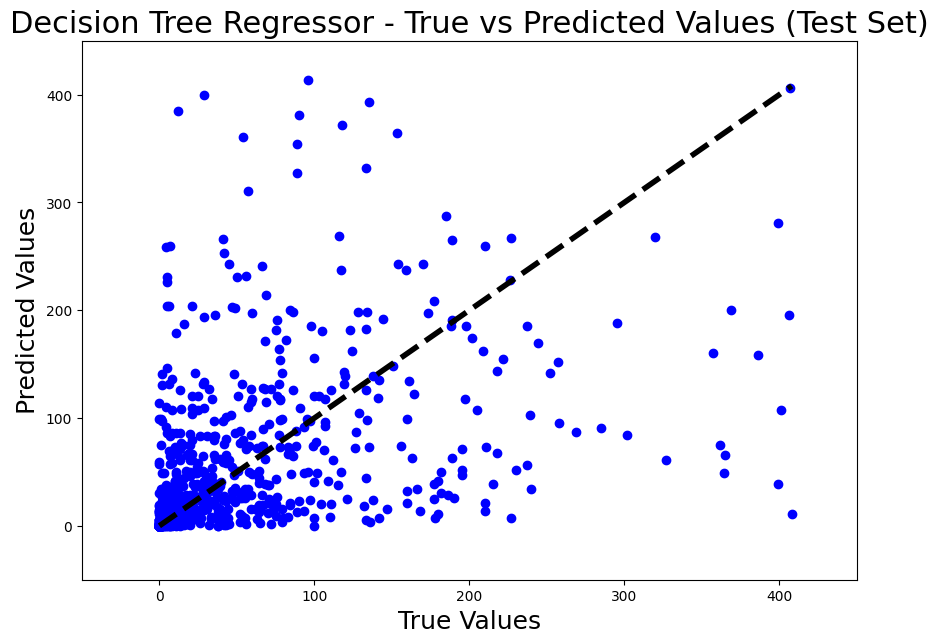

Random Forest Regressor
Feature Importances:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │   0.192791   │
│ Average_Volume_USD          │   0.0321737  │
│ Average_DPM                 │   0.0398183  │
│ Unique_Symbols_Traded       │   0.0360256  │
│ Peak_Trading_Times          │   0.0175642  │
│ Profit_Loss_Variability     │   0.0323724  │
│ Average_Trade_Duration      │   0.0372074  │
│ Average_Commission          │   0.0253558  │
│ Average_Swaps               │   0.0471167  │
│ Average_Profit              │   0.0573744  │
│ average_net_deposit         │   0.0692237  │
│ Buy_Percentage              │   0.0316461  │
│ TP/SL Hit Ratio             │   0.211066   │
│ Reward_Risk_Ratio           │   0.0241131  │
│ Ratio_Profitable_Trades     │   0.0396721  │
│ net_deposit_frequency_ratio │   0.0574414  │
│ country                     │   0.0259815  │
│ account_curre

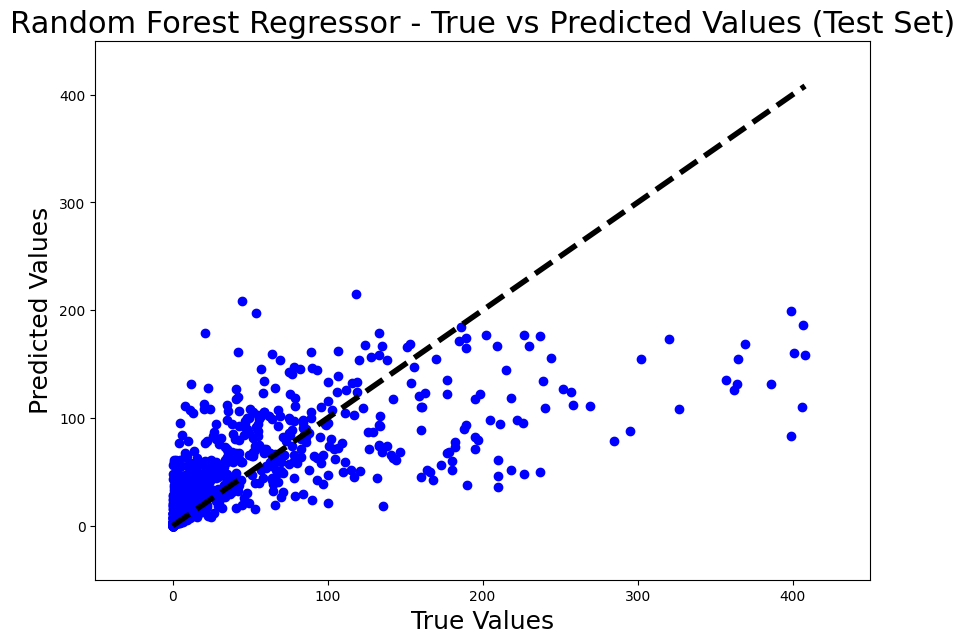

XGBoost Regressor
Feature Importances:
╭─────────────────────────────┬──────────────╮
│ Feature                     │   Importance │
├─────────────────────────────┼──────────────┤
│ Trading_Frequency           │    0.0795329 │
│ Average_Volume_USD          │    0.025156  │
│ Average_DPM                 │    0.0558407 │
│ Unique_Symbols_Traded       │    0.0390561 │
│ Peak_Trading_Times          │    0.0289648 │
│ Profit_Loss_Variability     │    0.03206   │
│ Average_Trade_Duration      │    0.0313605 │
│ Average_Commission          │    0.087931  │
│ Average_Swaps               │    0.0578664 │
│ Average_Profit              │    0.0542448 │
│ average_net_deposit         │    0.0457208 │
│ Buy_Percentage              │    0.0421512 │
│ TP/SL Hit Ratio             │    0.165584  │
│ Reward_Risk_Ratio           │    0.0630246 │
│ Ratio_Profitable_Trades     │    0.0402554 │
│ net_deposit_frequency_ratio │    0.0303246 │
│ country                     │    0.0399574 │
│ account_currency   

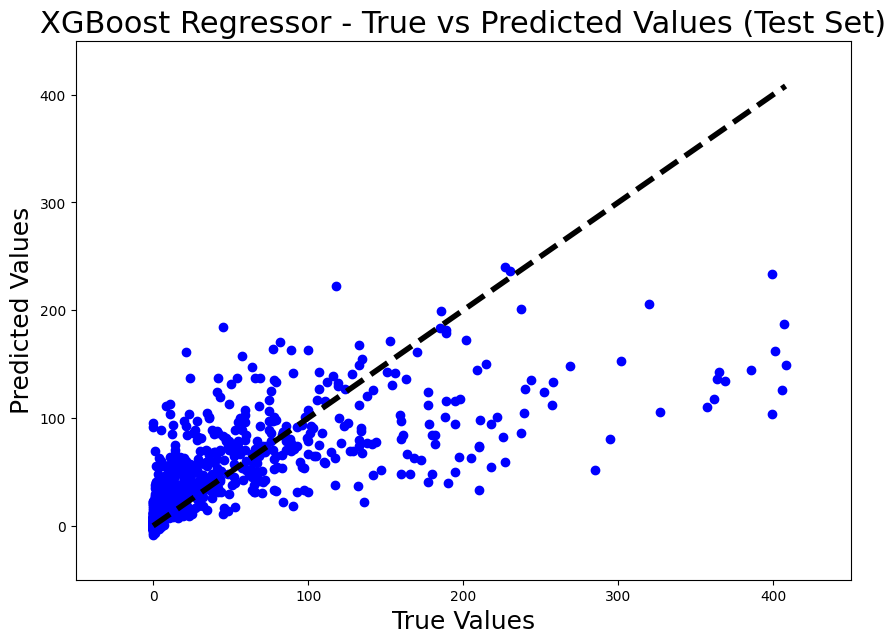

Neural Network Regressor
Feature importance or coefficients not available for this model.
╭────────────────────────────────┬───────────╮
│ Validation                     │     Value │
├────────────────────────────────┼───────────┤
│ Mean Absolute Error (MAE)      │   41.5427 │
│ Mean Squared Error (MSE)       │ 5583.89   │
│ Root Mean Squared Error (RMSE) │   74.7254 │
│ R-squared (R2)                 │    0.0314 │
╰────────────────────────────────┴───────────╯

╭────────────────────────────────┬───────────╮
│ Testing                        │     Value │
├────────────────────────────────┼───────────┤
│ Mean Absolute Error (MAE)      │   37.945  │
│ Mean Squared Error (MSE)       │ 3957.72   │
│ Root Mean Squared Error (RMSE) │   62.9104 │
│ R-squared (R2)                 │    0.2234 │
╰────────────────────────────────┴───────────╯



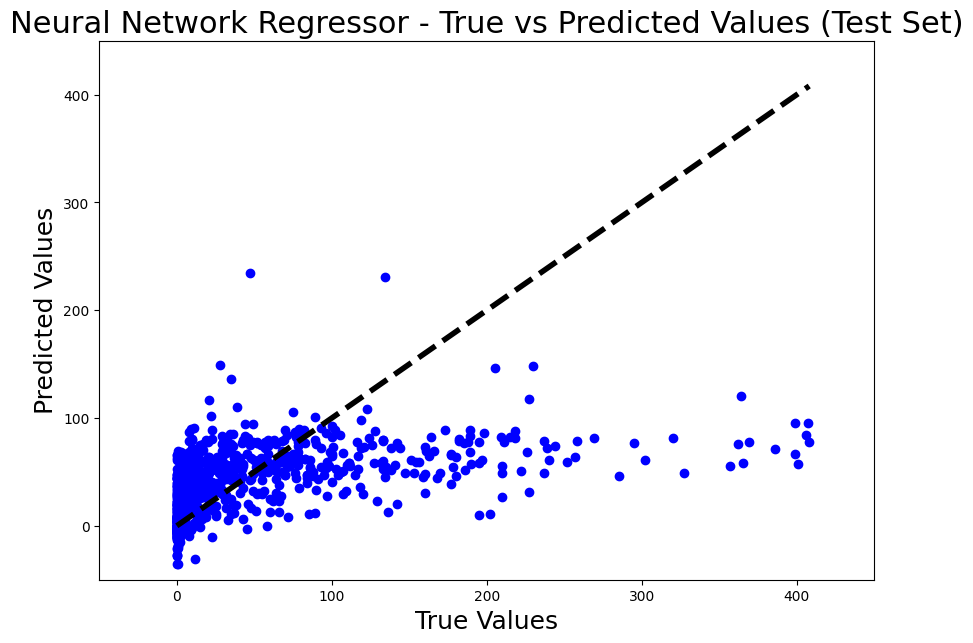

Linear Regression
Feature Coefficients:
╭─────────────────────────────┬───────────────╮
│ Feature                     │   Coefficient │
├─────────────────────────────┼───────────────┤
│ Trading_Frequency           │  -0.0026692   │
│ Average_Volume_USD          │   0.0213855   │
│ Average_DPM                 │  -0.184283    │
│ Unique_Symbols_Traded       │   6.56435     │
│ Peak_Trading_Times          │   8.39047     │
│ Profit_Loss_Variability     │   0.284673    │
│ Average_Trade_Duration      │   1.65143     │
│ Average_Commission          │   0.202508    │
│ Average_Swaps               │   0.000224666 │
│ Average_Profit              │  -0.0135522   │
│ average_net_deposit         │  -0.0368888   │
│ Buy_Percentage              │   0.112901    │
│ TP/SL Hit Ratio             │   0.0352525   │
│ Reward_Risk_Ratio           │  -0.00991145  │
│ Ratio_Profitable_Trades     │  29.0558      │
│ net_deposit_frequency_ratio │  -8.10303     │
│ country                     │  -0.0512779   │


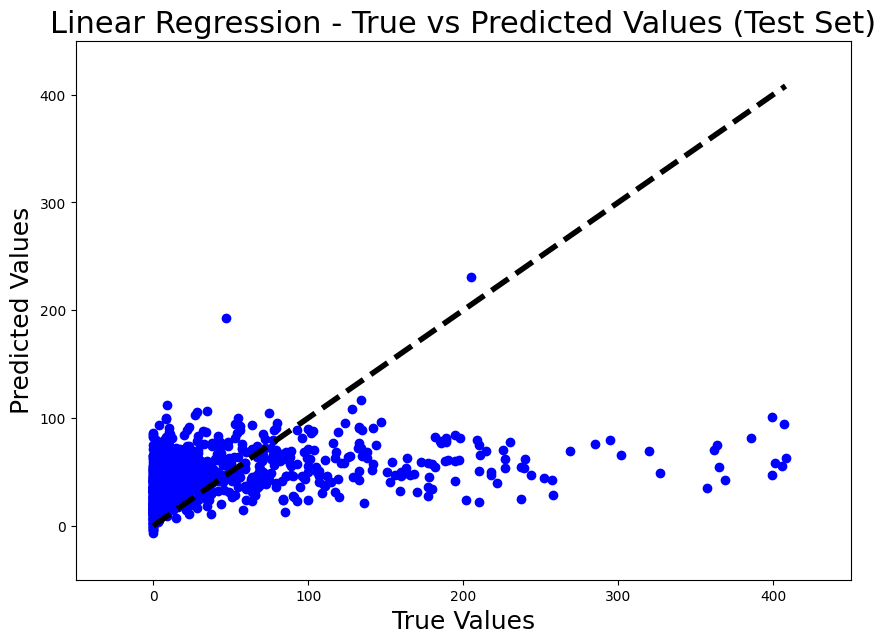

Ridge Regression
Feature Coefficients:
╭─────────────────────────────┬───────────────╮
│ Feature                     │   Coefficient │
├─────────────────────────────┼───────────────┤
│ Trading_Frequency           │  -0.00267722  │
│ Average_Volume_USD          │   0.0213751   │
│ Average_DPM                 │  -0.183058    │
│ Unique_Symbols_Traded       │   6.56512     │
│ Peak_Trading_Times          │   8.38878     │
│ Profit_Loss_Variability     │   0.284442    │
│ Average_Trade_Duration      │   1.65149     │
│ Average_Commission          │   0.202453    │
│ Average_Swaps               │   0.000218304 │
│ Average_Profit              │  -0.013489    │
│ average_net_deposit         │  -0.0373521   │
│ Buy_Percentage              │   0.112944    │
│ TP/SL Hit Ratio             │   0.0352892   │
│ Reward_Risk_Ratio           │  -0.00990675  │
│ Ratio_Profitable_Trades     │  28.9473      │
│ net_deposit_frequency_ratio │  -7.54147     │
│ country                     │  -0.051304    │
│

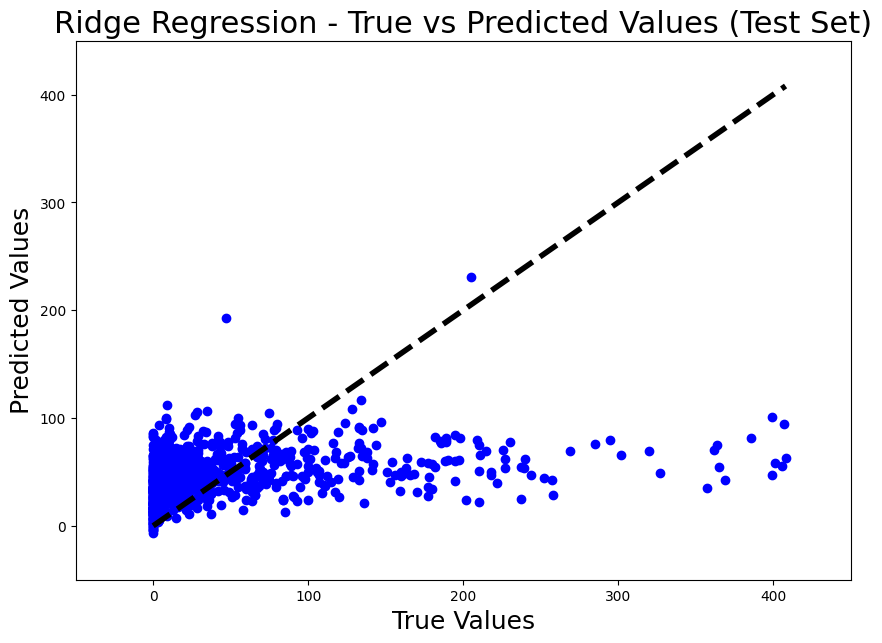

Lasso Regression
Feature Coefficients:
╭─────────────────────────────┬───────────────╮
│ Feature                     │   Coefficient │
├─────────────────────────────┼───────────────┤
│ Trading_Frequency           │  -0.00347022  │
│ Average_Volume_USD          │   0.0178136   │
│ Average_DPM                 │  -0           │
│ Unique_Symbols_Traded       │   5.94211     │
│ Peak_Trading_Times          │   6.7805      │
│ Profit_Loss_Variability     │   0.268259    │
│ Average_Trade_Duration      │   1.47535     │
│ Average_Commission          │   0.0871643   │
│ Average_Swaps               │  -4.05603e-05 │
│ Average_Profit              │  -0.00193614  │
│ average_net_deposit         │  -0.0371163   │
│ Buy_Percentage              │   0.122171    │
│ TP/SL Hit Ratio             │   0.0409658   │
│ Reward_Risk_Ratio           │  -0.0094334   │
│ Ratio_Profitable_Trades     │  15.644       │
│ net_deposit_frequency_ratio │  -0           │
│ country                     │  -0.0507667   │
│

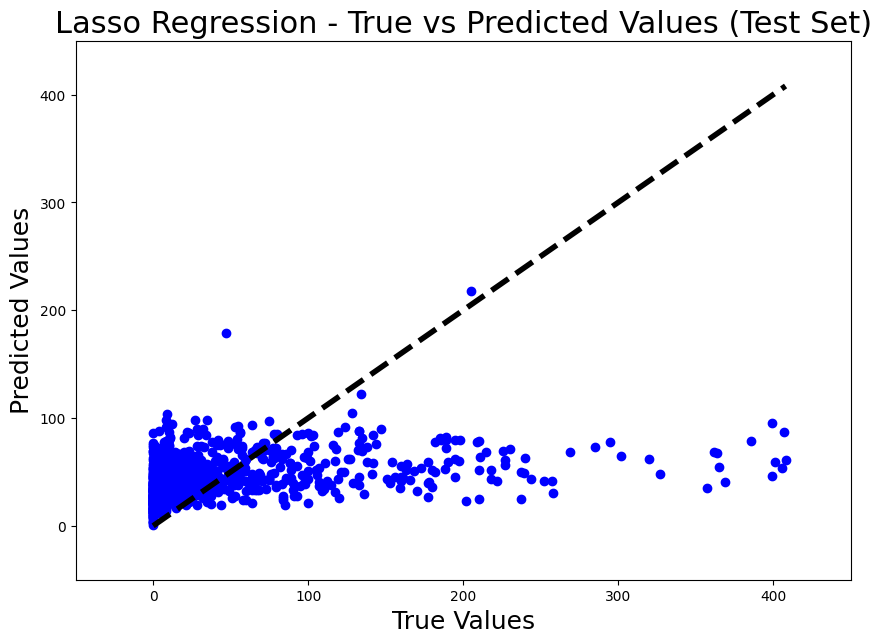

KNeighbors Regressor
Feature importance or coefficients not available for this model.
╭────────────────────────────────┬───────────╮
│ Validation                     │     Value │
├────────────────────────────────┼───────────┤
│ Mean Absolute Error (MAE)      │   39.2081 │
│ Mean Squared Error (MSE)       │ 4697.85   │
│ Root Mean Squared Error (RMSE) │   68.5409 │
│ R-squared (R2)                 │    0.1851 │
╰────────────────────────────────┴───────────╯

╭────────────────────────────────┬───────────╮
│ Testing                        │     Value │
├────────────────────────────────┼───────────┤
│ Mean Absolute Error (MAE)      │   38.7369 │
│ Mean Squared Error (MSE)       │ 4167.87   │
│ Root Mean Squared Error (RMSE) │   64.559  │
│ R-squared (R2)                 │    0.1822 │
╰────────────────────────────────┴───────────╯



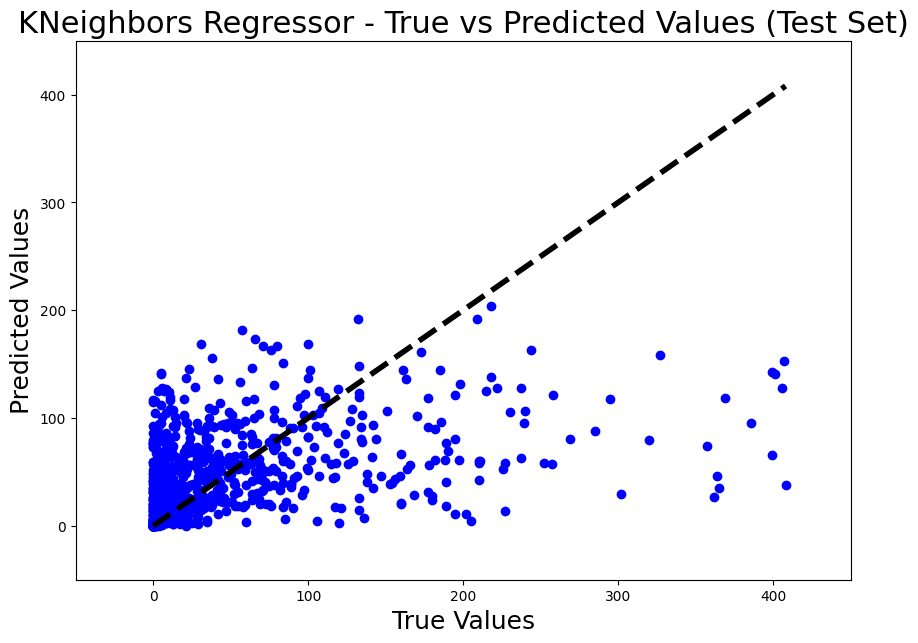

Support Vector Regressor
Feature importance or coefficients not available for this model.
╭────────────────────────────────┬───────────╮
│ Validation                     │     Value │
├────────────────────────────────┼───────────┤
│ Mean Absolute Error (MAE)      │   44.929  │
│ Mean Squared Error (MSE)       │ 6848.96   │
│ Root Mean Squared Error (RMSE) │   82.7584 │
│ R-squared (R2)                 │   -0.188  │
╰────────────────────────────────┴───────────╯

╭────────────────────────────────┬───────────╮
│ Testing                        │     Value │
├────────────────────────────────┼───────────┤
│ Mean Absolute Error (MAE)      │   41.6404 │
│ Mean Squared Error (MSE)       │ 5945.34   │
│ Root Mean Squared Error (RMSE) │   77.106  │
│ R-squared (R2)                 │   -0.1666 │
╰────────────────────────────────┴───────────╯



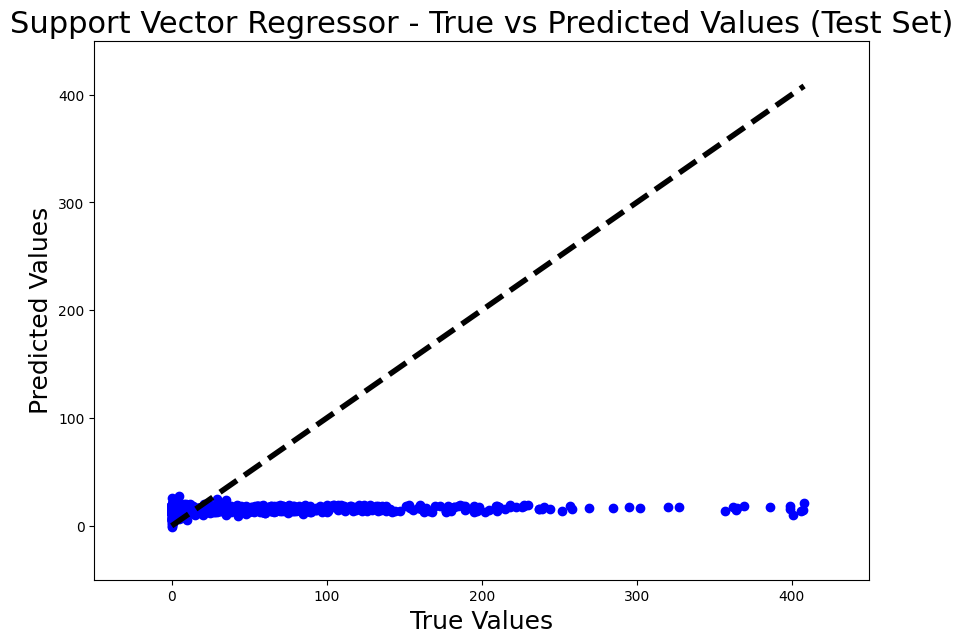

In [47]:
# Train and evaluate regression models
for name, model in regression_models.items():
    print(f"{name}")
    # Train the model on the training set
    model.fit(X_train, y_train)

    DisplayFeatureImportanceOrCoefficients(model)

    # Evaluate Metrics on Model
    DisplayMetrics(model, X_val, y_val, "Validation")
    y_test_pred = DisplayMetrics(model, X_test, y_test, "Testing")

    PerformPlot(name, y_test_pred)

    # Save the trained model to a file
    joblib.dump(model, f'Webpage/SavedModels/{name.replace(" ", "_")}_model.pkl')